In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data prep for simulation

## BSM flow by 5 minutes

In [74]:
bsm_data_train = pd.read_csv('data/train/bsm_data_train.csv')
bsm_data_test = pd.read_csv('data/test/bsm_data_test_outliers.csv')

bsm_data_train['MessageReceivedDate'] = pd.to_datetime(bsm_data_train['MessageReceivedDate'])
bsm_data_test['MessageReceivedDate'] = pd.to_datetime(bsm_data_test['MessageReceivedDate'])

combined_bsm_data = pd.concat([bsm_data_train, bsm_data_test], ignore_index=True)
combined_bsm_data = combined_bsm_data.sort_values(by=['MessageReceivedDate'],ignore_index=True)

ground_truth = combined_bsm_data.groupby(pd.Grouper(key='MessageReceivedDate', freq='5T')).size().reset_index(name='count')
ground_truth.rename(columns={'MessageReceivedDate': 'timestamp'}, inplace=True)
ground_truth = ground_truth.sort_values(by=['timestamp'],ignore_index=True)
ground_truth.head()

C:\Users\lebed\AppData\Local\Temp\ipykernel_8484\3530125437.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ground_truth = combined_bsm_data.groupby(pd.Grouper(key='MessageReceivedDate', freq='5T')).size().reset_index(name='count')


,timestamp,count
0,2023-07-01 00:00:00,100
1,2023-07-01 00:05:00,89
2,2023-07-01 00:10:00,125
3,2023-07-01 00:15:00,123
4,2023-07-01 00:20:00,122


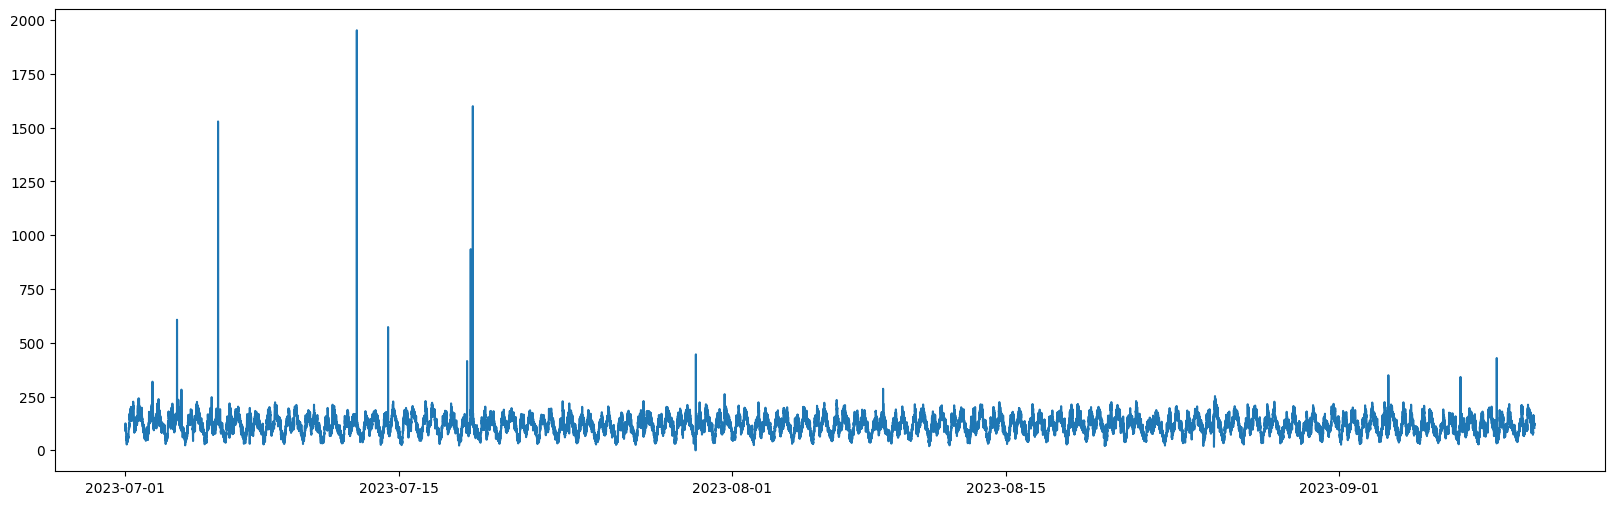

In [75]:
plt.figure(figsize=(20, 6))
plt.plot(ground_truth['timestamp'], ground_truth['count'])
plt.show()

## Anomalies by 5 minutes

In [84]:
y_train = pd.read_csv('data/tmp/train_y.csv',usecols=['timestamp', 'actualAnomaly'])
y_test = pd.read_csv('data/tmp/test_y.csv',usecols=['timestamp', 'actualAnomaly'])

y_train['timestamp'] = pd.to_datetime(y_train['timestamp'])
y_test['timestamp'] = pd.to_datetime(y_test['timestamp'])

combined_anomalies = pd.concat([y_train, y_test], ignore_index=True)
combined_anomalies = combined_anomalies.sort_values(by=['timestamp'],ignore_index=True)

combined_anomalies = combined_anomalies.groupby(pd.Grouper(key='timestamp', freq='5T'))["actualAnomaly"].sum().reset_index(name='actualAnomaly')
combined_anomalies['actualAnomaly'] = combined_anomalies['actualAnomaly'].apply(lambda x: 1 if x >= 1 else 0)
combined_anomalies["actualAnomaly"].value_counts()

C:\Users\lebed\AppData\Local\Temp\ipykernel_8484\3443619638.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  combined_anomalies = combined_anomalies.groupby(pd.Grouper(key='timestamp', freq='5T'))["actualAnomaly"].sum().reset_index(name='actualAnomaly')


actualAnomaly
0    20686
1       50
Name: count, dtype: int64

## Arrival distribution dictionray

In [62]:
profile_value_dict = pd.read_csv('data/train/arrival_profile_value.csv')
profile_value_dict

,checkin_terminal,airline_grouped_hash,arrival_profile,value,season
0,B,7bac920cc30511dfb81ca2242b293990,180.0,0.008569,S23
1,B,7bac920cc30511dfb81ca2242b293990,185.0,0.008135,S23
2,B,7bac920cc30511dfb81ca2242b293990,190.0,0.007548,S23
3,B,7bac920cc30511dfb81ca2242b293990,195.0,0.007107,S23
4,B,7bac920cc30511dfb81ca2242b293990,200.0,0.006526,S23
...,...,...,...,...,...
1315,C,4bba3ab232fc6c57e7dbb1f5932b61d0,140.0,0.038291,S23
1316,C,4bba3ab232fc6c57e7dbb1f5932b61d0,145.0,0.034149,S23
1317,C,4bba3ab232fc6c57e7dbb1f5932b61d0,150.0,0.035884,S23
1318,C,4bba3ab232fc6c57e7dbb1f5932b61d0,155.0,0.032785,S23


In [ ]:
diff_airlines = profile_value_dict['airline_grouped_hash'].unique()
print(diff_airlines.size)
for airline_group in diff_airlines:
    distribution = profile_value_dict.loc[profile_value_dict['airline_grouped_hash'] == airline_group]
    distribution = distribution.sort_values(by=['arrival_profile'],ignore_index=True)
    print(airline_group)
    plt.figure(figsize=(8, 6))
    plt.plot(distribution['arrival_profile'], distribution['value'])
    plt.scatter(distribution['arrival_profile'], distribution['value'], label='Data Points', c='red')
    plt.xlabel('Minutes befor the flight')
    plt.ylabel('%')
    plt.title('Scatter for ' + airline_group)
    plt.legend()
    plt.show()

In [73]:
#There is a separate split for the groups of airlines that are served in both terminals
test = profile_value_dict.loc[profile_value_dict['airline_grouped_hash'] == '655610c16fda311d29ed2360a1ffcbd1']
test = test.sort_values(by=['arrival_profile'],ignore_index=True)
test.head(20)

,checkin_terminal,airline_grouped_hash,arrival_profile,value,season
0,B,655610c16fda311d29ed2360a1ffcbd1,40.0,0.045931,S23
1,C,655610c16fda311d29ed2360a1ffcbd1,40.0,0.009467,S23
2,C,655610c16fda311d29ed2360a1ffcbd1,45.0,0.012771,S23
3,B,655610c16fda311d29ed2360a1ffcbd1,45.0,0.052451,S23
4,C,655610c16fda311d29ed2360a1ffcbd1,50.0,0.018032,S23
5,B,655610c16fda311d29ed2360a1ffcbd1,50.0,0.061939,S23
6,C,655610c16fda311d29ed2360a1ffcbd1,55.0,0.021264,S23
7,B,655610c16fda311d29ed2360a1ffcbd1,55.0,0.065749,S23
8,C,655610c16fda311d29ed2360a1ffcbd1,60.0,0.026200,S23
9,B,655610c16fda311d29ed2360a1ffcbd1,60.0,0.068578,S23


## Bag number distribution

In [93]:
df_grouped = combined_bsm_data.groupby('pax_id_hash').count()
df_grouped['i_id'].value_counts()

i_id
1     1827722
2      220185
3       25322
4       13079
5        2190
6        1111
8         320
7          80
10         45
9          25
Name: count, dtype: int64

In [86]:
rasp = pd.read_csv('data/train/flight_rasp_data.csv')
rasp['t_st'] = pd.to_datetime(rasp['t_st'])
rasp

,i_id,departure_terminal,checkin_terminal,airline_grouped_hash,cco_hash,flt_hash,t_st,m_city_rus1,m_city_rus2,config
0,8634957.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,6a2feef8ed6a9fe76d6b3f30f02150b4,2023-07-08 00:05:00,Москва,Челябинск,156
1,8634958.0,C,C,3ab7806fac7c2de105704d4ff29dd581,3ab7806fac7c2de105704d4ff29dd581,58d4d1e7b1e97b258c9ed0b37e02d087,2023-07-08 00:05:00,Москва,Шарм-эль-Шейх,202
2,8634961.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,471c75ee6643a10934502bdafee198fb,2023-07-08 00:10:00,Москва,Горно-Алтайск,158
3,8634962.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,9adeb82fffb5444e81fa0ce8ad8afe7a,2023-07-08 00:10:00,Москва,Казань,156
4,8634963.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,83cdcec08fbf90370fcf53bdd56604ff,2023-07-08 00:15:00,Москва,Абакан,196
...,...,...,...,...,...,...,...,...,...,...
28262,8698569.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,bc1ad6e8f86c42a371aff945535baebb,2023-09-12 23:55:00,Москва,Н.Новгород,87
28263,8698571.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,729c68884bd359ade15d5f163166738a,2023-09-12 23:55:00,Москва,Красноярск,156
28264,8698572.0,C,C,f7adf0ba18d705092fa0a1e2f2c0bafb,f7adf0ba18d705092fa0a1e2f2c0bafb,d757719ed7c2b66dd17dcee2a3cb29f4,2023-09-12 23:55:00,Москва,Минск,140
28265,8699624.0,B,B,7bac920cc30511dfb81ca2242b293990,f7adf0ba18d705092fa0a1e2f2c0bafb,418ef6127e44214882c61e372e866691,2023-09-12 17:05:00,Москва,Южно-Сахалинск,427


In [52]:
#Tables with number of BSMs per minute
df_train = pd.read_csv('data/tmp/df_grouped.csv')
df_test = pd.read_csv('data/tmp/df_grouped_test.csv')


df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])


df_combined = pd.concat([df_train, df_test], ignore_index=True)



df_combined = df_combined.drop(columns=['minute'])
df_combined = df_combined.sort_values(by=['timestamp'],ignore_index=True)


#Tables with BSM inflow to dentify the number of bags per person
bsm_data_train = pd.read_csv('data/train/bsm_data_train.csv')
bsm_data_test = pd.read_csv('data/test/bsm_data_test_outliers.csv')

combined_bsm_data = pd.concat([bsm_data_train, bsm_data_test], ignore_index=True)

#planned flight schedule


,checkin_terminal,airline_grouped_hash,arrival_profile,value,season
0,B,7bac920cc30511dfb81ca2242b293990,180.0,0.008569,S23
1,B,7bac920cc30511dfb81ca2242b293990,185.0,0.008135,S23
2,B,7bac920cc30511dfb81ca2242b293990,190.0,0.007548,S23
3,B,7bac920cc30511dfb81ca2242b293990,195.0,0.007107,S23
4,B,7bac920cc30511dfb81ca2242b293990,200.0,0.006526,S23
...,...,...,...,...,...
1315,C,4bba3ab232fc6c57e7dbb1f5932b61d0,140.0,0.038291,S23
1316,C,4bba3ab232fc6c57e7dbb1f5932b61d0,145.0,0.034149,S23
1317,C,4bba3ab232fc6c57e7dbb1f5932b61d0,150.0,0.035884,S23
1318,C,4bba3ab232fc6c57e7dbb1f5932b61d0,155.0,0.032785,S23


In [ ]:
diff_airlines = profile_value['airline_grouped_hash'].unique()
for x in diff_airlines:
    testing = profile_value.loc[profile_value['airline_grouped_hash'] == x]
    testing = testing.sort_values(by=['arrival_profile'],ignore_index=True)

    # Creating the scatter plot
    plt.figure(figsize=(8, 6))
    plt.plot(testing['arrival_profile'], testing['value'], label='Data Points')
    plt.scatter(testing['arrival_profile'], testing['value'], label='Data Points', c='red')

    # Adding labels and title
    plt.xlabel('Number')
    plt.ylabel('Value')
    plt.title('Scatter for ' + x)
    plt.legend()

    # Display the plot
    plt.show()
